In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from sklearn.model_selection import train_test_split

## Import dataset

In [2]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


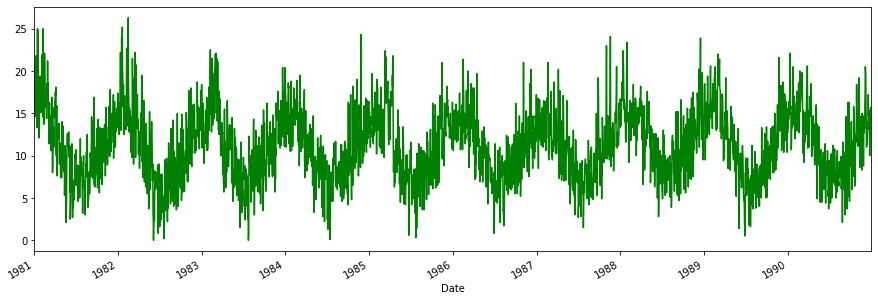

In [3]:
df.Temp.plot(figsize=(15,5), color='g');

## Dataset Splitting

In [4]:
## Pada data time series data tidak boleh dishuffle(diacak) 
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

## Dataset dan Dataloader

In [5]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [32]:
seq_len = 21
bs = 16

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (139, 21, 1)
Note: last 0 data excluded

(N, S, F): (34, 21, 1)
Note: last 15 data excluded



- N = Jumlah data
- S = Squence
- F = Feature

## Arsitektur dan config

In [33]:
class GRU(nn.Module):
    def __init__(self, input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [34]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size":1,
    "hidden_size":64,
    "num_layers":3,
    "dropout":0
})

## Training Preparation

In [35]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

## Training

In [36]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 128.2626 | Test_cost  = 113.6608 | 




Epoch     2
Train_cost  = 91.5294 | Test_cost  = 78.8381 | 




Epoch     3
Train_cost  = 65.5341 | Test_cost  = 61.7397 | 




Epoch     4
Train_cost  = 52.6969 | Test_cost  = 51.5025 | 




Epoch     5
Train_cost  = 44.1077 | Test_cost  = 43.7515 | 




Epoch     6
Train_cost  = 37.4974 | Test_cost  = 37.6234 | 




Epoch     7
Train_cost  = 32.2931 | Test_cost  = 32.7533 | 




Epoch     8
Train_cost  = 28.2069 | Test_cost  = 28.9159 | 




Epoch     9
Train_cost  = 25.0385 | Test_cost  = 25.9299 | 




Epoch    10
Train_cost  = 22.6188 | Test_cost  = 23.6357 | 




Epoch    11
Train_cost  = 20.7997 | Test_cost  = 21.8946 | 




Epoch    12
Train_cost  = 19.4537 | Test_cost  = 20.5888 | 




Epoch    13
Train_cost  = 18.4739 | Test_cost  = 19.6206 | 




Epoch    14
Train_cost  = 17.7726 | Test_cost  = 18.9105 | 




Epoch    15
Train_cost  = 17.2792 | Test_cost  = 18.3947 | 




Epoch    16
Train_cost  = 16.9381 | Test_cost  = 18.0235 | 




Epoch    17
Train_cost  = 16.7064 | Test_cost  = 17.7581 | 




Epoch    18
Train_cost  = 16.5516 | Test_cost  = 17.5693 | 




Epoch    19
Train_cost  = 16.4500 | Test_cost  = 17.4354 | 




Epoch    20
Train_cost  = 16.3841 | Test_cost  = 17.3406 | 


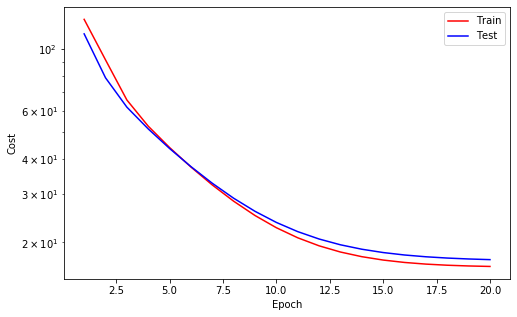



Epoch    21
Train_cost  = 16.3419 | Test_cost  = 17.2733 | 




Epoch    22
Train_cost  = 16.3151 | Test_cost  = 17.2253 | 




Epoch    23
Train_cost  = 16.2979 | Test_cost  = 17.1911 | 




Epoch    24
Train_cost  = 16.2868 | Test_cost  = 17.1664 | 




Epoch    25
Train_cost  = 16.2794 | Test_cost  = 17.1486 | 




Epoch    26
Train_cost  = 16.2741 | Test_cost  = 17.1357 | 




Epoch    27
Train_cost  = 16.2701 | Test_cost  = 17.1262 | 




Epoch    28
Train_cost  = 16.2669 | Test_cost  = 17.1193 | 




Epoch    29
Train_cost  = 16.2641 | Test_cost  = 17.1141 | 




Epoch    30
Train_cost  = 16.2615 | Test_cost  = 17.1102 | 




Epoch    31
Train_cost  = 16.2590 | Test_cost  = 17.1072 | 




Epoch    32
Train_cost  = 16.2566 | Test_cost  = 17.1048 | 




Epoch    33
Train_cost  = 16.2542 | Test_cost  = 17.1029 | 




Epoch    34
Train_cost  = 16.2518 | Test_cost  = 17.1013 | 




Epoch    35
Train_cost  = 16.2494 | Test_cost  = 17.0999 | 




Epoch    36
Train_cost  = 16.2470 | Test_cost  = 17.0986 | 




Epoch    37
Train_cost  = 16.2445 | Test_cost  = 17.0974 | 




Epoch    38
Train_cost  = 16.2420 | Test_cost  = 17.0963 | 




Epoch    39
Train_cost  = 16.2395 | Test_cost  = 17.0951 | 




Epoch    40
Train_cost  = 16.2369 | Test_cost  = 17.0940 | 


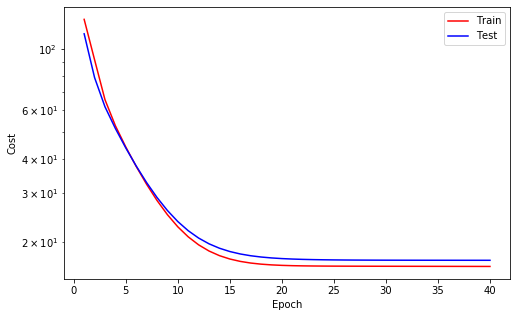



Epoch    41
Train_cost  = 16.2343 | Test_cost  = 17.0929 | 




Epoch    42
Train_cost  = 16.2317 | Test_cost  = 17.0917 | 




Epoch    43
Train_cost  = 16.2291 | Test_cost  = 17.0906 | 




Epoch    44
Train_cost  = 16.2265 | Test_cost  = 17.0895 | 




Epoch    45
Train_cost  = 16.2239 | Test_cost  = 17.0883 | 




Epoch    46
Train_cost  = 16.2212 | Test_cost  = 17.0871 | 




Epoch    47
Train_cost  = 16.2186 | Test_cost  = 17.0859 | 




Epoch    48
Train_cost  = 16.2160 | Test_cost  = 17.0847 | 




Epoch    49
Train_cost  = 16.2134 | Test_cost  = 17.0835 | 




Epoch    50
Train_cost  = 16.2108 | Test_cost  = 17.0823 | 




Epoch    51
Train_cost  = 16.2082 | Test_cost  = 17.0811 | 




Epoch    52
Train_cost  = 16.2056 | Test_cost  = 17.0798 | 




Epoch    53
Train_cost  = 16.2030 | Test_cost  = 17.0786 | 




Epoch    54
Train_cost  = 16.2005 | Test_cost  = 17.0773 | 




Epoch    55
Train_cost  = 16.1980 | Test_cost  = 17.0761 | 




Epoch    56
Train_cost  = 16.1954 | Test_cost  = 17.0748 | 




Epoch    57
Train_cost  = 16.1929 | Test_cost  = 17.0735 | 




Epoch    58
Train_cost  = 16.1904 | Test_cost  = 17.0721 | 




Epoch    59
Train_cost  = 16.1878 | Test_cost  = 17.0708 | 




Epoch    60
Train_cost  = 16.1852 | Test_cost  = 17.0693 | 


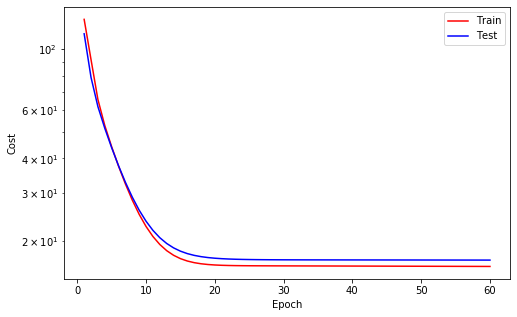



Epoch    61
Train_cost  = 16.1826 | Test_cost  = 17.0678 | 




Epoch    62
Train_cost  = 16.1798 | Test_cost  = 17.0662 | 




Epoch    63
Train_cost  = 16.1769 | Test_cost  = 17.0644 | 




Epoch    64
Train_cost  = 16.1738 | Test_cost  = 17.0624 | 




Epoch    65
Train_cost  = 16.1704 | Test_cost  = 17.0601 | 




Epoch    66
Train_cost  = 16.1665 | Test_cost  = 17.0573 | 




Epoch    67
Train_cost  = 16.1618 | Test_cost  = 17.0536 | 




Epoch    68
Train_cost  = 16.1559 | Test_cost  = 17.0484 | 




Epoch    69
Train_cost  = 16.1479 | Test_cost  = 17.0403 | 




Epoch    70
Train_cost  = 16.1354 | Test_cost  = 17.0254 | 




Epoch    71
Train_cost  = 16.1122 | Test_cost  = 16.9902 | 




Epoch    72
Train_cost  = 16.0496 | Test_cost  = 16.8465 | 




Epoch    73
Train_cost  = 15.5823 | Test_cost  = 14.8792 | 




Epoch    74
Train_cost  = 13.5866 | Test_cost  = 13.9665 | 




Epoch    75
Train_cost  = 12.4647 | Test_cost  = 12.4761 | 




Epoch    76
Train_cost  = 11.3333 | Test_cost  = 11.0315 | 




Epoch    77
Train_cost  = 10.3602 | Test_cost  = 10.0087 | 




Epoch    78
Train_cost  = 9.6624 | Test_cost  = 9.4895 | 




Epoch    79
Train_cost  = 9.2384 | Test_cost  = 9.0837 | 




Epoch    80
Train_cost  = 8.9399 | Test_cost  = 8.4456 | 


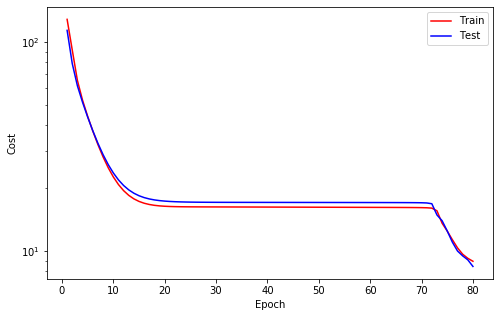



Epoch    81
Train_cost  = 8.6045 | Test_cost  = 7.8236 | 




Epoch    82
Train_cost  = 8.1840 | Test_cost  = 7.4832 | 




Epoch    83
Train_cost  = 7.8176 | Test_cost  = 7.2081 | 




Epoch    84
Train_cost  = 7.5749 | Test_cost  = 6.9739 | 




Epoch    85
Train_cost  = 7.4008 | Test_cost  = 6.7899 | 




Epoch    86
Train_cost  = 7.2618 | Test_cost  = 6.6416 | 




Epoch    87
Train_cost  = 7.1459 | Test_cost  = 6.5213 | 




Epoch    88
Train_cost  = 7.0478 | Test_cost  = 6.4166 | 




Epoch    89
Train_cost  = 6.9619 | Test_cost  = 6.3190 | 




Epoch    90
Train_cost  = 6.8857 | Test_cost  = 6.2260 | 




Epoch    91
Train_cost  = 6.8173 | Test_cost  = 6.1395 | 




Epoch    92
Train_cost  = 6.7562 | Test_cost  = 6.0602 | 




Epoch    93
Train_cost  = 6.7017 | Test_cost  = 5.9879 | 




Epoch    94
Train_cost  = 6.6525 | Test_cost  = 5.9228 | 




Epoch    95
Train_cost  = 6.6078 | Test_cost  = 5.8648 | 




Epoch    96
Train_cost  = 6.5668 | Test_cost  = 5.8131 | 




Epoch    97
Train_cost  = 6.5295 | Test_cost  = 5.7668 | 




Epoch    98
Train_cost  = 6.4957 | Test_cost  = 5.7256 | 




Epoch    99
Train_cost  = 6.4651 | Test_cost  = 5.6892 | 




Epoch   100
Train_cost  = 6.4373 | Test_cost  = 5.6572 | 


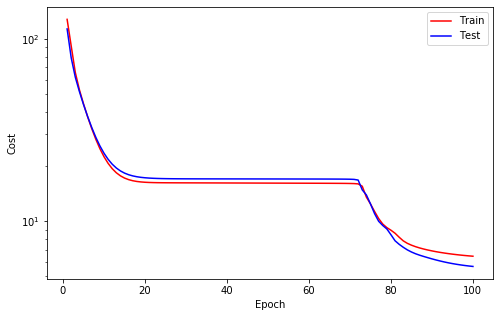



Epoch   101
Train_cost  = 6.4121 | Test_cost  = 5.6291 | 




Epoch   102
Train_cost  = 6.3893 | Test_cost  = 5.6047 | 




Epoch   103
Train_cost  = 6.3687 | Test_cost  = 5.5840 | 




Epoch   104
Train_cost  = 6.3502 | Test_cost  = 5.5671 | 




Epoch   105
Train_cost  = 6.3334 | Test_cost  = 5.5541 | 




Epoch   106
Train_cost  = 6.3182 | Test_cost  = 5.5449 | 




Epoch   107
Train_cost  = 6.3041 | Test_cost  = 5.5391 | 




Epoch   108
Train_cost  = 6.2909 | Test_cost  = 5.5357 | 




Epoch   109
Train_cost  = 6.2780 | Test_cost  = 5.5331 | 




Epoch   110
Train_cost  = 6.2651 | Test_cost  = 5.5284 | 




Epoch   111
Train_cost  = 6.2514 | Test_cost  = 5.5188 | 




Epoch   112
Train_cost  = 6.2363 | Test_cost  = 5.5023 | 




Epoch   113
Train_cost  = 6.2195 | Test_cost  = 5.4786 | 




Epoch   114
Train_cost  = 6.2007 | Test_cost  = 5.4496 | 




Epoch   115
Train_cost  = 6.1802 | Test_cost  = 5.4186 | 




Epoch   116
Train_cost  = 6.1587 | Test_cost  = 5.3893 | 




Epoch   117
Train_cost  = 6.1371 | Test_cost  = 5.3637 | 




Epoch   118
Train_cost  = 6.1165 | Test_cost  = 5.3428 | 




Epoch   119
Train_cost  = 6.0973 | Test_cost  = 5.3259 | 




Epoch   120
Train_cost  = 6.0799 | Test_cost  = 5.3121 | 


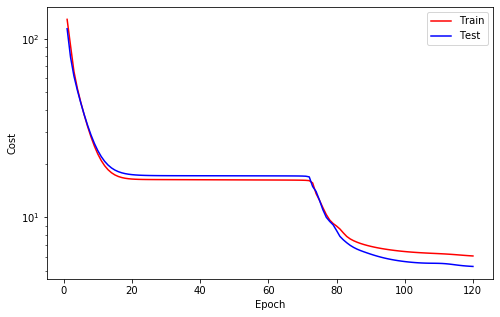



Epoch   121
Train_cost  = 6.0641 | Test_cost  = 5.3007 | 




Epoch   122
Train_cost  = 6.0497 | Test_cost  = 5.2907 | 




Epoch   123
Train_cost  = 6.0364 | Test_cost  = 5.2819 | 




Epoch   124
Train_cost  = 6.0239 | Test_cost  = 5.2738 | 




Epoch   125
Train_cost  = 6.0119 | Test_cost  = 5.2662 | 




Epoch   126
Train_cost  = 6.0004 | Test_cost  = 5.2590 | 




Epoch   127
Train_cost  = 5.9891 | Test_cost  = 5.2523 | 




Epoch   128
Train_cost  = 5.9781 | Test_cost  = 5.2459 | 




Epoch   129
Train_cost  = 5.9673 | Test_cost  = 5.2398 | 




Epoch   130
Train_cost  = 5.9567 | Test_cost  = 5.2341 | 




Epoch   131
Train_cost  = 5.9462 | Test_cost  = 5.2287 | 




Epoch   132
Train_cost  = 5.9358 | Test_cost  = 5.2237 | 




Epoch   133
Train_cost  = 5.9256 | Test_cost  = 5.2191 | 




Epoch   134
Train_cost  = 5.9156 | Test_cost  = 5.2150 | 




Epoch   135
Train_cost  = 5.9057 | Test_cost  = 5.2112 | 




Epoch   136
Train_cost  = 5.8959 | Test_cost  = 5.2079 | 




Epoch   137
Train_cost  = 5.8864 | Test_cost  = 5.2049 | 




Epoch   138
Train_cost  = 5.8770 | Test_cost  = 5.2024 | 




Epoch   139
Train_cost  = 5.8678 | Test_cost  = 5.2002 | 




Epoch   140
Train_cost  = 5.8587 | Test_cost  = 5.1984 | 


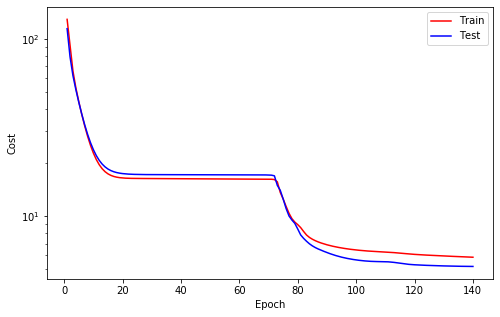



Epoch   141
Train_cost  = 5.8499 | Test_cost  = 5.1970 | 




Epoch   142
Train_cost  = 5.8411 | Test_cost  = 5.1959 | 




Epoch   143
Train_cost  = 5.8326 | Test_cost  = 5.1951 | 




Epoch   144
Train_cost  = 5.8241 | Test_cost  = 5.1946 | 




Epoch   145
Train_cost  = 5.8158 | Test_cost  = 5.1945 | 




Epoch   146
Train_cost  = 5.8076 | Test_cost  = 5.1946 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1945




Epoch   147
Train_cost  = 5.7995 | Test_cost  = 5.1950 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1945




Epoch   148
Train_cost  = 5.7915 | Test_cost  = 5.1956 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1945




Epoch   149
Train_cost  = 5.7835 | Test_cost  = 5.1965 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1945




Epoch   150
Train_cost  = 5.7755 | Test_cost  = 5.1975 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1945
==> Execute Early Stopping at epoch: 150 | Best test_cost: 5.1945
==> Best model is saved at model/gru


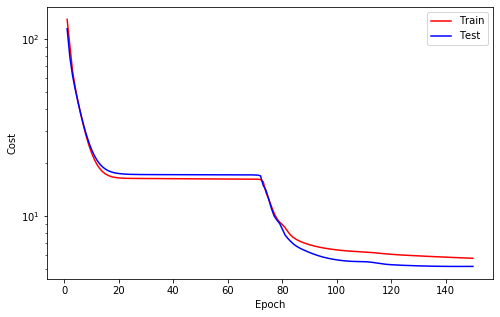

In [37]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [38]:
from utils import data4pred, pred4pred

In [39]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

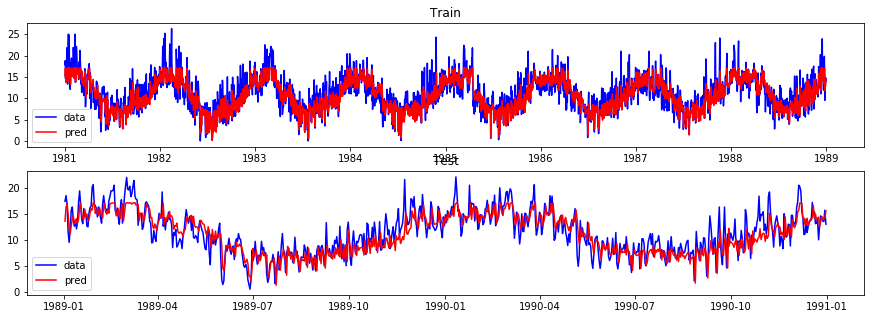

In [40]:
# Data For Pred
plt.figure(figsize=(15,5))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

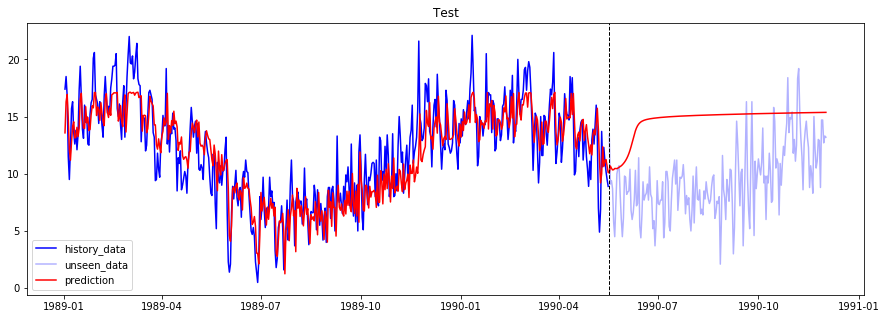

In [41]:
# Pred for pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

#### Umumnya pred for pred hanya dapat memprediksi 2 hari kedepan. untuk hari selanjutnya tidak dipakai karena terjadi domino effect yang terjadi apabila disuatu hari tersebut terjadi kesalahan maka hari selanjutnya akan menjadi salah terus 